# Interactive Options Pricing Analysis

This notebook provides an interactive environment to explore options pricing using the Black-Scholes model and Monte Carlo simulations. Adjust parameters, visualize greeks (vega, theta, delta), and understand hedging and the impact of non-normal return distributions.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from ipywidgets import interact, FloatSlider, VBox, HBox, Output
from IPython.display import display, Markdown

## Black-Scholes Model

The Black-Scholes model is a mathematical model for pricing European options. Adjust the parameters below to see how the option price and greeks change.

In [2]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
    return price

def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = stats.norm.cdf(d1) if option_type == 'call' else -stats.norm.cdf(-d1)
    vega = S * stats.norm.pdf(d1) * np.sqrt(T)
    theta = (-S * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * stats.norm.cdf(d2 if option_type == 'call' else -d2))
    return {'delta': delta, 'vega': vega, 'theta': theta}

In [ ]:
def interactive_black_scholes():
    S_slider = FloatSlider(value=9.81, min=5, max=15, step=0.01, description='Spot (S)')
    K_slider = FloatSlider(value=9.81, min=5, max=15, step=0.1, description='Strike (K)')
    T_slider = FloatSlider(value=1, min=0.01, max=2, step=0.01, description='Time (T, yrs)')
    r_slider = FloatSlider(value=0.01, min=0, max=0.1, step=0.001, description='Rate (r)')
    sigma_slider = FloatSlider(value=0.2, min=0.01, max=1, step=0.01, description='Volatility (σ)')
    option_type = ['call', 'put']
    out = Output()

    def update(S, K, T, r, sigma, option_type):
        with out:
            out.clear_output()
            price = black_scholes_price(S, K, T, r, sigma, option_type)
            greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)
            display(Markdown(f"**Option Price:** {price:.2f}"))
            display(Markdown(f"**Delta:** {greeks['delta']:.4f}  |  **Vega:** {greeks['vega']:.4f}  |  **Theta:** {greeks['theta']:.4f}"))
    
    interact(update, S=S_slider, K=K_slider, T=T_slider, r=r_slider, sigma=sigma_slider, option_type=option_type)
    display(out)

interactive_black_scholes()

interactive(children=(FloatSlider(value=9.81, description='Spot (S)', max=15.0, min=5.0, step=0.01), FloatSlid…

Output()

## Exploring Vega and Theta

- **Vega** measures sensitivity of the option price to changes in volatility. Higher vega means the option price is more sensitive to volatility changes.
- **Theta** measures the rate of decline in the value of an option due to the passage of time (time decay).

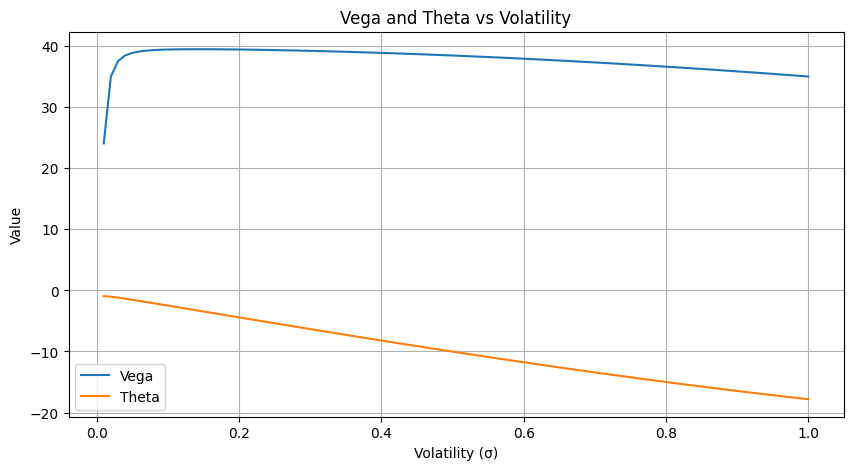

In [5]:
def plot_vega_theta(S=100, K=100, T=1, r=0.01, sigma_range=(0.01, 1)):
    sigmas = np.linspace(*sigma_range, 100)
    vegas = [black_scholes_greeks(S, K, T, r, s)['vega'] for s in sigmas]
    thetas = [black_scholes_greeks(S, K, T, r, s)['theta'] for s in sigmas]
    plt.figure(figsize=(10,5))
    plt.plot(sigmas, vegas, label='Vega')
    plt.plot(sigmas, thetas, label='Theta')
    plt.xlabel('Volatility (σ)')
    plt.ylabel('Value')
    plt.title('Vega and Theta vs Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_vega_theta()

## Delta and Hedging

- **Delta** measures the sensitivity of the option price to changes in the underlying asset price.
- Delta hedging involves holding a position in the underlying asset to offset the delta risk of an option position.

In [6]:
def delta_hedge_example(S=100, K=100, T=1, r=0.01, sigma=0.2, option_type='call', option_qty=10):
    greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)
    delta = greeks['delta']
    hedge_position = -delta * option_qty
    print(f"Delta per option: {delta:.4f}")
    print(f"To hedge {option_qty} options, hold {hedge_position:.2f} shares of the underlying asset.")

delta_hedge_example()

Delta per option: 0.5596
To hedge 10 options, hold -5.60 shares of the underlying asset.


## Monte Carlo Simulation for Non-Normal Returns

When returns are not normally distributed, we can use Monte Carlo simulation to estimate option prices and numerically calculate greeks.

In [8]:
def monte_carlo_option_price(S, K, T, r, sigma, option_type='call', n_paths=10000, dist='normal'):
    np.random.seed(42)
    if dist == 'normal':
        returns = np.random.normal((r - 0.5 * sigma ** 2) * T, sigma * np.sqrt(T), n_paths)
    elif dist == 't':
        returns = np.random.standard_t(df=5, size=n_paths) * sigma * np.sqrt(T) + (r - 0.5 * sigma ** 2) * T
    else:
        raise ValueError('Unknown distribution')
    S_T = S * np.exp(returns)
    if option_type == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

def numerical_greek(S, K, T, r, sigma, greek, option_type='call', dist='normal', h=1e-2):
    if greek == 'delta':
        price_up = monte_carlo_option_price(S + h, K, T, r, sigma, option_type, dist=dist)
        price_down = monte_carlo_option_price(S - h, K, T, r, sigma, option_type, dist=dist)
        return (price_up - price_down) / (2 * h)
    elif greek == 'vega':
        price_up = monte_carlo_option_price(S, K, T, r, sigma + h, option_type, dist=dist)
        price_down = monte_carlo_option_price(S, K, T, r, sigma - h, option_type, dist=dist)
        return (price_up - price_down) / (2 * h)
    elif greek == 'theta':
        price_up = monte_carlo_option_price(S, K, T + h, r, sigma, option_type, dist=dist)
        price_down = monte_carlo_option_price(S, K, T - h, r, sigma, option_type, dist=dist)
        return (price_up - price_down) / (2 * h)
    else:
        raise ValueError('Unknown greek')

# Example usage:
S, K, T, r, sigma = 100, 100, 1, 0.01, 0.2
print('Monte Carlo price (t-dist):', monte_carlo_option_price(S, K, T, r, sigma, dist='t'))
print('Numerical delta (t-dist):', numerical_greek(S, K, T, r, sigma, 'delta', dist='t'))

Monte Carlo price (t-dist): 10.777287667372974
Numerical delta (t-dist): 0.5758500590803628
